### Plotting photometry traces
based on this: https://www.tdt.com/support/python-sdk/offline-analysis-examples/licking-bout-epoc-filtering/

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
matplotlib.rcParams['font.size'] = 18 # set font size for all figures

from tdt import read_block, download_demo_data, StructType
%config Completer.use_jedi = False

In [48]:
BLOCK_PATH = '/data/gergely/invivo_DATA/fiberPhotometry/dock05b-2-210224-110203/EEGCamFP2-210310-111053/'
data = read_block(BLOCK_PATH)
print(data)
print('===============')
print(data.info)

Found Synapse note file: /data/gergely/invivo_DATA/fiberPhotometry/dock05b-2-210224-110203/EEGCamFP2-210310-111053/Notes.txt
read from t=0s to t=1243.91s
epocs	[struct]
snips	[struct]
streams	[struct]
scalars	[struct]
info	[struct]
time_ranges:	array([[ 0.],
       [inf]])
tankpath:	'/data/gergely/invivo_DATA/fiberPhotometry/dock05b-2-210224-110203'
blockname:	'EEGCamFP2-210310-111053'
start_date:	datetime.datetime(2021, 3, 10, 14, 10, 57, 999999)
utc_start_time:	'14:10:57'
stop_date:	datetime.datetime(2021, 3, 10, 14, 31, 41, 910283)
utc_stop_time:	'14:31:41'
duration:	datetime.timedelta(0, 1243, 910284)
stream_channel:	0
snip_channel:	0
experiment:	'EEGCamFP2'
subject:	'dock05b-2'
user:	'User'
start:	'11:10:58am 03/10/2021'
stop:	'11:31:43am 03/10/2021'


In [49]:
data.streams.keys()

dict_keys(['_405N', '_465N', 'EMGP', 'Raw_', 'Fi1r'])

In [50]:
GCAMP = '_465N' # GCaMP channel
ISOS = '_405N' # Isosbestic channel
LICK = 'Ler_'

In [51]:
print(data.streams._465N.fs)
print(data.streams._405N.fs)

1017.2526245117188
1017.2526245117188


In [52]:
npts = len(data.streams[GCAMP].data)
time_x = np.linspace(1, npts, npts) / data.streams[GCAMP].fs

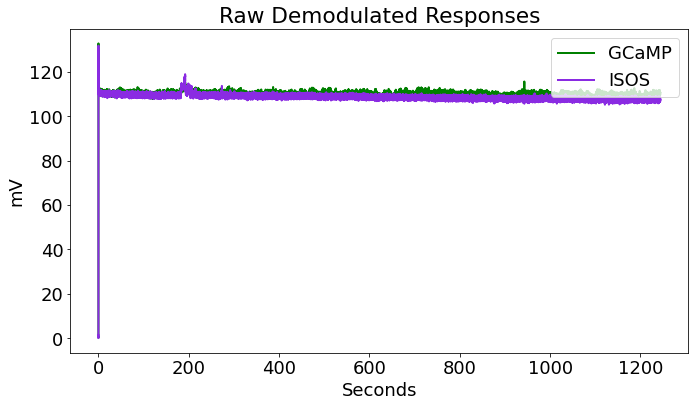

In [53]:
fig1 = plt.figure(figsize=(10,6))
ax0 = fig1.add_subplot(111)
p1, = ax0.plot(time_x, data.streams[GCAMP].data, linewidth=2,
               color='green', label='GCaMP')
p2, = ax0.plot(time_x, data.streams[ISOS].data, linewidth=2,
               color='blueviolet', label='ISOS')

ax0.set_ylabel('mV')
ax0.set_xlabel('Seconds')
ax0.set_title('Raw Demodulated Responses')
ax0.legend(handles=[p1,p2], loc='upper right')
fig1.tight_layout()
plt.show()

<b>Artifact Removal<br></b>
There is often a large artifact on the onset of LEDs turning on<br>
Remove data below a set time t

In [54]:
t = 8
inds = np.where(time_x > t)
ind = inds[0][0]
time_x = time_x[ind:] # go from ind to final index
data.streams[GCAMP].data = data.streams[GCAMP].data[ind:]
data.streams[ISOS].data = data.streams[ISOS].data[ind:]

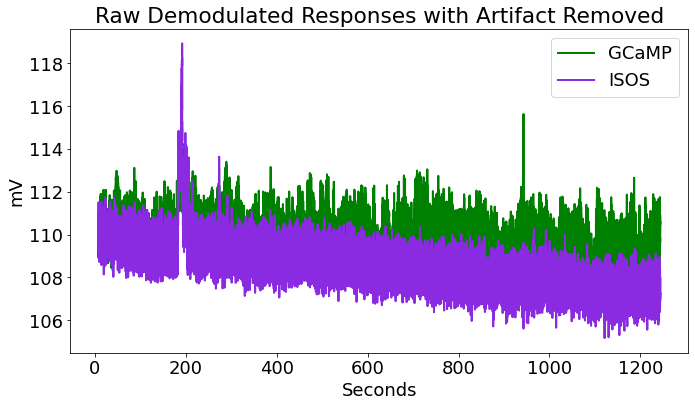

In [55]:
fig2 = plt.figure(figsize=(10, 6))
ax1 = fig2.add_subplot(111)
p1, = ax1.plot(time_x, data.streams[GCAMP].data, linewidth=2,
               color='green', label='GCaMP')
p2, = ax1.plot(time_x, data.streams[ISOS].data, linewidth=2,
               color='blueviolet', label='ISOS')

ax1.set_ylabel('mV')
ax1.set_xlabel('Seconds')
ax1.set_title('Raw Demodulated Responses with Artifact Removed')
ax1.legend(handles=[p1,p2],loc='upper right')
fig2.tight_layout()
plt.show()

<b>Downsample Data Doing Local Averaging</b><br>

Average around every Nth point and downsample Nx


In [56]:
N = 100 # Average every 10 samples into 1 value
F405 = []
F465 = []

for i in range(0, len(data.streams[GCAMP].data), N):
    # This is the moving window mean
    mean_wnd = np.mean(data.streams[GCAMP].data[i:i+N-1])
    F465.append(mean_wnd)

data.streams[GCAMP].data = F465

for i in range(0, len(data.streams[ISOS].data), N):
    F405.append(np.mean(data.streams[ISOS].data[i:i+N-1]))
    
data.streams[ISOS].data = F405

Decimate time array to match length of demodulated stream

In [57]:
time_x = time_x[::N] # go from beginning to end of array in steps on N
time_x = time_x[:len(data.streams[GCAMP].data)]

<b>Detrending and dFF</b><br>
Full trace dFF according to Lerner et al. 2015<br>
dFF using 405 fit as baseline

In [58]:
x = np.array(data.streams[ISOS].data)
y = np.array(data.streams[GCAMP].data)
bls = np.polyfit(x, y, 1)
Y_fit_all = np.multiply(bls[0], x) + bls[1]
Y_dF_all = y - Y_fit_all

dFF = np.multiply(100, np.divide(Y_dF_all, Y_fit_all))
std_dFF = np.std(dFF)

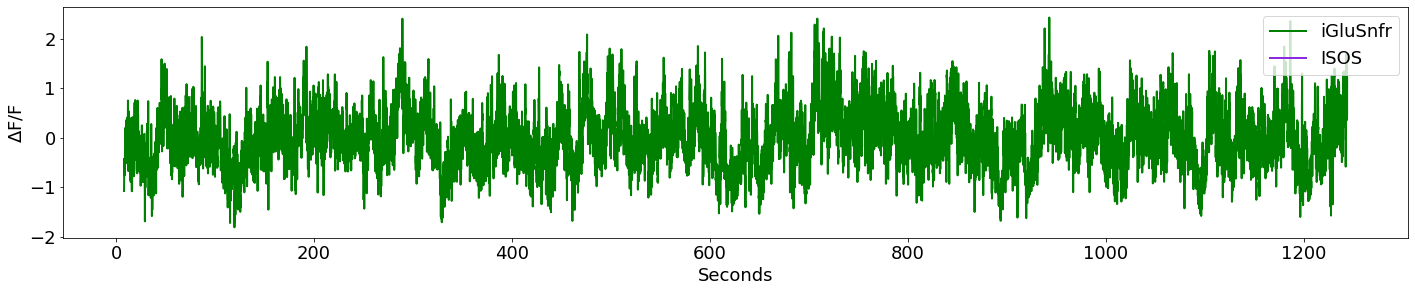

In [60]:
fig3 = plt.figure(figsize=(20,12))
ax2 = fig3.add_subplot(311)

p1, = ax2.plot(time_x, dFF, linewidth=2,
               color='green', label='iGluSnfr')
# p2, = ax2.plot(LICK_x, y_scale*LICK_y+y_shift, linewidth=2,
#                color='dodgerblue', label='Lick Event')
ax2.set_ylabel(r'$\Delta$F/F')
ax2.set_xlabel('Seconds')
# ax2.set_title('dFF with Lick Epocs')
ax2.legend(handles=[p1,p2], loc='upper right')
fig3.tight_layout()
plt.show()